## Analysis of restaurant grading and 311 complaints in NYC

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


### 1. Data loading and cleaning

In [2]:
# Dataset loading and exploration
data_311 = pd.read_csv("nyc_311_data.csv")
data_rest = pd.read_csv("nyc_restaurant_results.csv")

print("311 Data columns:\n",data_311.columns, "\n")
print("Hygiene data columns:\n",data_rest.columns)

311 Data columns:
 Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip', 'city',
       'landmark', 'status', 'bbl', 'borough', 'latitude', 'longitude'],
      dtype='object') 

Hygiene data columns:
 Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location Point1'],
      dtype='object')


In [16]:
# Dropping null values in ZIP codes
data_311.dropna(subset="incident_zip", how="any", inplace=True)
data_rest.dropna(subset="ZIPCODE", how="any", inplace=True)

# Dropping N, Z and P values in the GRADE column
data_rest = data_rest[data_rest["GRADE"].isin(["A", "B", "C"])]

### 2. Exploratory analysis
#### 2.1 Grading in NYC

Count:
 GRADE
A    93730
B    16726
C    11313
Name: count, dtype: int64 

By percent:
 GRADE
A    77.0
B    13.7
C     9.3
Name: proportion, dtype: float64


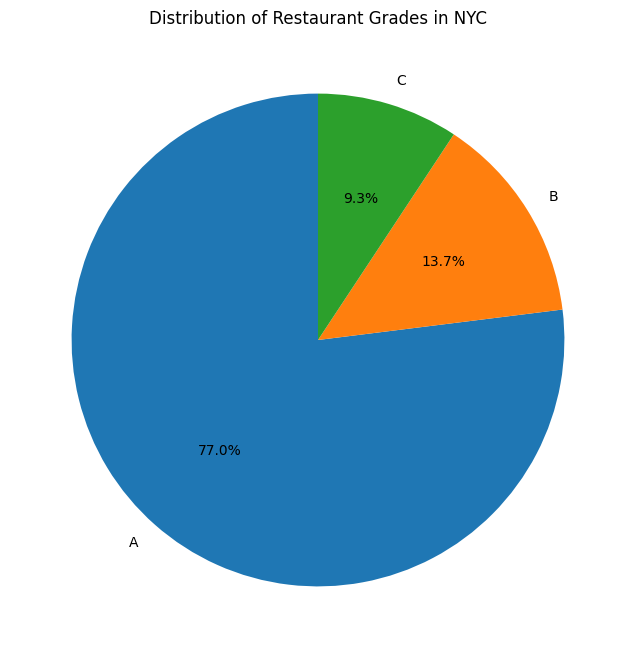

In [4]:
# Whole NYC
nyc_grades = data_rest.GRADE.value_counts()
print("Count:\n", nyc_grades, "\n")

nyc_grades_pct = (data_rest.GRADE.value_counts(normalize=True)*100).round(1)
print("By percent:\n", nyc_grades_pct)

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(data_rest.GRADE.value_counts().values, labels=data_rest.GRADE.value_counts().index, autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Restaurant Grades in NYC")
plt.show()

#### 2.2 Grading for each Borough

GRADE              A     B     C
BORO                            
Bronx           8406  1875   982
Brooklyn       24632  4394  2943
Manhattan      35882  5526  3961
Queens         21122  4286  3171
Staten Island   3688   645   256 

GRADE             A     B     C
BORO                           
Bronx          74.6  16.6   8.7
Brooklyn       77.0  13.7   9.2
Manhattan      79.1  12.2   8.7
Queens         73.9  15.0  11.1
Staten Island  80.4  14.1   5.6


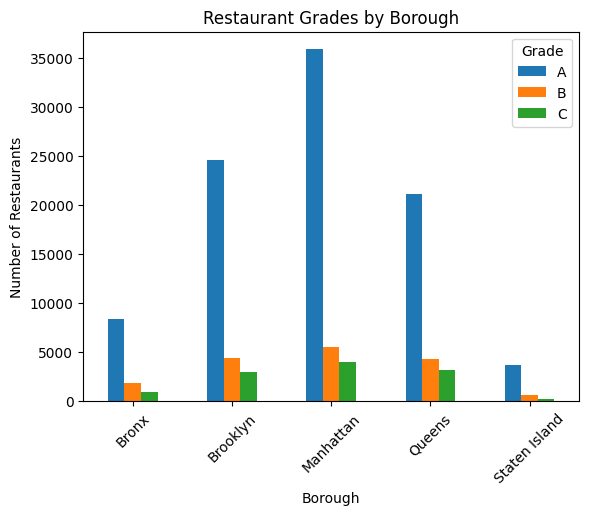

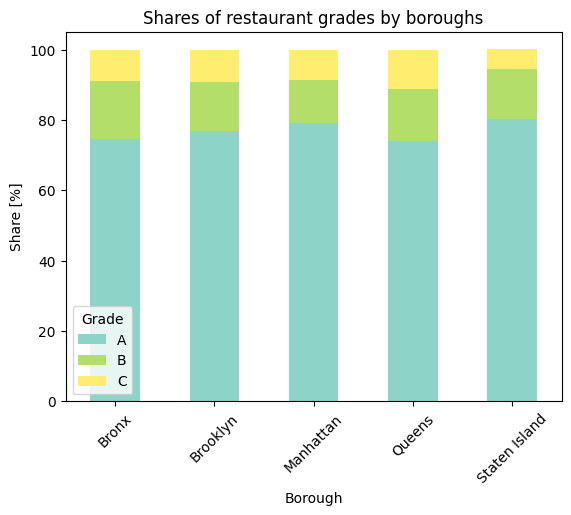

In [5]:
# For each borough
boro_grades = data_rest.groupby(["BORO", "GRADE"]).size().unstack(fill_value=0)
print(boro_grades,"\n")

boro_share = (boro_grades.div(boro_grades.sum(axis=1), axis=0)*100).round(1)
print(boro_share)

# Bar chart
boro_grades.plot(kind="bar")
plt.title("Restaurant Grades by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Restaurants")
plt.legend(title="Grade")
plt.xticks(rotation=45)
plt.show()

# Stacked bar chart
boro_share.plot(kind="bar", stacked=True, colormap="Set3")
plt.title("Shares of restaurant grades by boroughs")
plt.ylabel("Share [%]")
plt.xlabel("Borough")
plt.legend(title="Grade")
plt.xticks(rotation=45)
plt.show()

#### 2.3 Grading for each ZIP code

In [6]:
zip_grades = data_rest.groupby(['ZIPCODE', 'GRADE']).size().unstack(fill_value=0)
zip_share = (zip_grades.div(zip_grades.sum(axis=1), axis=0)*100).round(1)
zip_grades = pd.concat({'count': zip_grades, 'share': zip_share}, axis=1)
zip_grades.head()

count           share            
GRADE       A    B    C     A     B     C
ZIPCODE                                  
10000.0     7    4    0  63.6  36.4   0.0
10001.0  2192  337  179  80.9  12.4   6.6
10002.0  1687  345  245  74.1  15.2  10.8
10003.0  2254  294  236  81.0  10.6   8.5
10004.0   516   79   53  79.6  12.2   8.2

#### 2.4 Correlation analysis

In [7]:
# Possible relevant complaints and location types on the 311 line
data_311["complaint_type"].unique()
data_311["location_type"].unique()

relevant_complaints = [
    "Food Poisoning",
    "Dirty Condition",
    "UNSANITARY CONDITION",
    "Rodent",
    "Mold",
    "Food Establishment",
    "Indoor Sewage",
    "Unsanitary Animal Facility",
    "Unsanitary Pigeon Condition"
]

filtered_311 = data_311[
    data_311["complaint_type"].isin(relevant_complaints) &
    data_311["location_type"].isin(["Club/Bar/Restaurant", "Restaurant/Bar/Deli/Bakery"])
]
# Filtered dataframe with relevant complaints
filtered_311.shape

(953, 16)

In [8]:
# Setting the data type of ZIP codes to integers
filtered_311.loc[:, "incident_zip"] = filtered_311["incident_zip"].astype(int)
zip_grades.index = zip_grades.index.astype(int)
zip_grades.head()

count           share            
GRADE       A    B    C     A     B     C
ZIPCODE                                  
10000       7    4    0  63.6  36.4   0.0
10001    2192  337  179  80.9  12.4   6.6
10002    1687  345  245  74.1  15.2  10.8
10003    2254  294  236  81.0  10.6   8.5
10004     516   79   53  79.6  12.2   8.2

In [9]:
# Computing n. of complaints for each ZIP code
zip_complaints = filtered_311.groupby("incident_zip").size()
zip_complaints.index = zip_complaints.index.astype(int)
zip_complaints.head()

incident_zip
10001    20
10002     7
10003    25
10004     1
10005     1
dtype: int64

In [10]:

bad_grades = ["B", "C"]
bad_share = zip_share[bad_grades].sum(axis=1)
zip_share_bc = bad_share.to_frame(name='bad_share')
zip_complaints_df = zip_complaints.to_frame(name="complaints")
zip_analysis = zip_share_bc[["bad_share"]].join(zip_complaints_df, how="inner")
zip_analysis.dropna(inplace=True)
zip_analysis.head()

,bad_share,complaints
10001.0,19.0,20
10002.0,26.0,7
10003.0,19.1,25
10004.0,20.4,1
10005.0,31.3,1


In [11]:
# Pearson's correlation
pearson_corr = zip_analysis["bad_share"].corr(zip_analysis["complaints"], method="pearson")

# Spearman's correlation
spearman_corr = zip_analysis["bad_share"].corr(zip_analysis["complaints"], method="spearman")

print("Pearson correlation:", pearson_corr.round(3))
print("Spearman correlation:", spearman_corr.round(3))

Pearson correlation: 0.136
Spearman correlation: 0.089


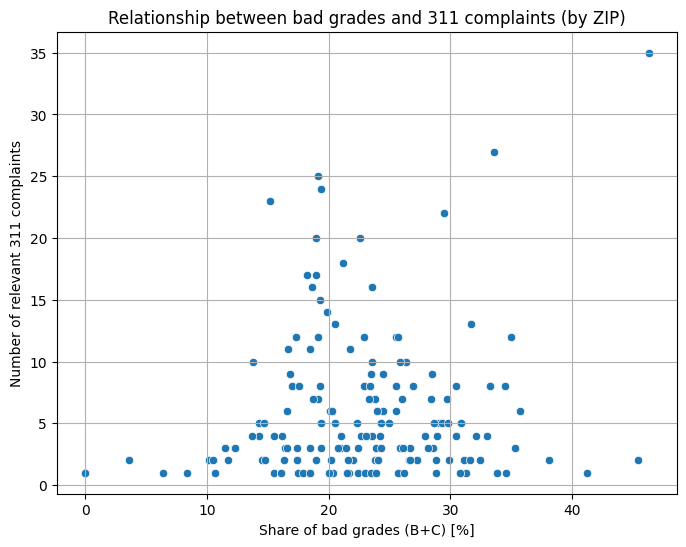

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=zip_analysis, x="bad_share", y="complaints")
plt.title("Relationship between bad grades and 311 complaints (by ZIP)")
plt.xlabel("Share of bad grades (B+C) [%]")
plt.ylabel("Number of relevant 311 complaints")
plt.grid(True)
plt.show()

### 3. Modeling the relationship with Linear Regression

In [13]:
X = zip_analysis["bad_share"]
X = sm.add_constant(X)
y = zip_analysis["complaints"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             complaints   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.990
Date:                Tue, 24 Jun 2025   Prob (F-statistic):             0.0857
Time:                        11:14:27   Log-Likelihood:                -512.45
No. Observations:                 161   AIC:                             1029.
Df Residuals:                     159   BIC:                             1035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4549      1.498      2.306      0.0